In [2]:
import torch
#from data import *
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from torch.optim import Adagrad
from torch.optim import Adam
from tqdm import tqdm
#from vae import *
#import argparse

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec


In [3]:
HIDDEN=64
BATCH_SIZE=32
EPOCHS=50
LR=2e-3
LATENT=64


#specify the device
device="cuda:0"

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim=2):
        """
            @param input_dim: input dimension of the data
            @param hidden_dim: hidden dimension of the MLPs
            @param latent_dim: output dimension of MLPs
            @------------------@
            @return: None
        """
        super(VAE,self).__init__()
        self.en = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim,latent_dim)
        
        self.de = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        self.final_layer=nn.Sequential(
            nn.Linear(hidden_dim,input_dim),
        )

        
          
    def encode(self,x):
        #x = torch.flatten(x)
        res = self.en(x)
        mu = self.mu(res)
        log_var = self.var(res)
        
        return mu,log_var
            
    def decode(self,x):
        res = self.de(x)
        res = self.final_layer(res)
        return res
    def reparameterize(self,mu,log_var):
        epsilon = torch.normal(mu,torch.exp(0.5 * log_var))
        return mu + log_var * epsilon
    def forward(self,x):
        mu, log_var = self.encode(x)
        norm = self.reparameterize(mu,log_var)
        res = self.decode(norm)
        return (res, x, mu,log_var)



    def loss_fc(self,x,label,*args):
        (res, x, mu, log_var) = self.forward(x)
        recon_loss = F.mse_loss(res,label)
        KL_divergence = torch.mean(-0.5 * torch.sum((1 + log_var - mu**2 - torch.exp(log_var)),dim=1), dim=0)
        KL_divergence.required_grad = True
        loss = recon_loss + KL_divergence
        
        return dict({'loss': loss, 'recon_loss': recon_loss, 'kl_loss': KL_divergence})



    def generate(self,x):
        return self.forward(x)[0]


In [5]:
from scipy.io import loadmat

def get_minibatch(x,batch_size,device='cpu'):
    indices = torch.randperm(x.shape[0])[:batch_size]
    return x[indices].reshape(batch_size, -1).to(device)
def get_data(path,nums=25000):
    img_data = scipy.io.loadmat(path)["data"].T / 255.
    img_data = torch.Tensor(img_data)
    img_data = get_minibatch(img_data,nums)
    img_data = img_data.to(device)
    distri = torch.zeros(img_data.shape)
    
    print(f"Shape of a data point: {img_data.shape}")
    print(f"Example data {img_data[0:1].shape}")
    return img_data

def add_noise(data, std=1/10.,device='cpu'):
    distri = torch.normal(torch.zeros(data.shape),torch.ones(data.shape) * std).to(device)
    return data + distri
    #print(distri)

Shape of a data point: torch.Size([65000, 784])
Example data torch.Size([1, 784])


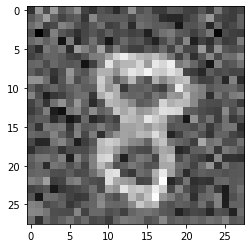

In [6]:
x = get_data("../Data/mnist.mat", nums=65000)
t = add_noise(x,std=1/4.,device=device).cpu().detach().numpy()
plt.imshow(t[0].reshape(28,28),cmap="gray")

In [7]:
def AEVB(data, model, optimizer, input_dim, output_dim,epochs, batch_size):
    full_loss, kld, recon = [],[],[]
    for epc in range(epochs):
        fl,kl,rec = 0,0,0
        steps = x.shape[0] // batch_size
        for _ in tqdm(range(steps)):
            batch = get_minibatch(x,batch_size,device)
            batch_noise = add_noise(batch, std=1/45., device=device)
            optimizer.zero_grad()
 
            losses = model.loss_fc(batch_noise,batch)
        
            fl += losses["loss"].item() / batch_size
            kl += losses["kl_loss"].item() / batch_size
            rec += losses["recon_loss"].item() / batch_size
        
            losses["loss"].backward()

            optimizer.step()
        fl /= steps; kl /= steps; rec /= steps
        full_loss.append(fl); kld.append(kl); recon.append(rec)
        print(f"Epoch {epc + 1}\tFull loss: {full_loss[-1]}\trecon loss: {recon[-1]}\tkl_divergence: {kld[-1]}")
        
    return model, full_loss, kld, recon 





In [8]:
#Model 
model = VAE(x.shape[1],HIDDEN,LATENT).to(device)
# Optimizer

optimizer = Adam(model.parameters(), lr=LR)

In [9]:
(model, full_loss, kld, recon) = AEVB(data=x,
                                      model=model,
                                      optimizer=optimizer,
                                      input_dim=x.shape[1],
                                      output_dim=x.shape[1],
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 236.41it/s]


Epoch 1	Full loss: 0.0033081704348276206	recon loss: 0.0014936315445268388	kl_divergence: 0.0018145388856579256


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 244.87it/s]


Epoch 2	Full loss: 0.001271870609220156	recon loss: 0.0010754295828791654	kl_divergence: 0.0001964410249366696


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 198.50it/s]


Epoch 3	Full loss: 0.0009518435681667518	recon loss: 0.0008892690898036168	kl_divergence: 6.257447879302904e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 223.01it/s]


Epoch 4	Full loss: 0.0007765228273532734	recon loss: 0.0007552628821013784	kl_divergence: 2.1259945509831478e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 221.35it/s]


Epoch 5	Full loss: 0.0006686868940219595	recon loss: 0.0006549687249801964	kl_divergence: 1.3718169099082211e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 197.80it/s]


Epoch 6	Full loss: 0.0005977401556710816	recon loss: 0.0005856176657092738	kl_divergence: 1.2122489517583988e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 193.63it/s]


Epoch 7	Full loss: 0.0005484911225860409	recon loss: 0.0005373773616006078	kl_divergence: 1.1113761830891532e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 194.32it/s]


Epoch 8	Full loss: 0.0005229958586425969	recon loss: 0.0005118309015546642	kl_divergence: 1.1164957130922106e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 193.66it/s]


Epoch 9	Full loss: 0.0004997051186470525	recon loss: 0.0004886895339955048	kl_divergence: 1.1015584837835133e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:11<00:00, 171.39it/s]


Epoch 10	Full loss: 0.0004862183488735536	recon loss: 0.0004755246252312629	kl_divergence: 1.0693723943216542e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 210.92it/s]


Epoch 11	Full loss: 0.0004788138080286967	recon loss: 0.00046787259462626547	kl_divergence: 1.0941213287792803e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 207.83it/s]


Epoch 12	Full loss: 0.0004686781512095319	recon loss: 0.0004581064035549002	kl_divergence: 1.0571747912568142e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 231.38it/s]


Epoch 13	Full loss: 0.00046047088199736234	recon loss: 0.0004499870799708853	kl_divergence: 1.0483801926168417e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 227.00it/s]


Epoch 14	Full loss: 0.00045221630422935413	recon loss: 0.0004418677958511486	kl_divergence: 1.034850857882283e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 189.50it/s]


Epoch 15	Full loss: 0.0004491962168956334	recon loss: 0.00043899064357628644	kl_divergence: 1.0205572932442272e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 197.36it/s]


Epoch 16	Full loss: 0.0004465627132054943	recon loss: 0.0004363487235054691	kl_divergence: 1.021398941342912e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 219.02it/s]


Epoch 17	Full loss: 0.0004406394894935965	recon loss: 0.0004308456120672551	kl_divergence: 9.793877440671185e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 216.61it/s]


Epoch 18	Full loss: 0.000439442280098839	recon loss: 0.0004296458222904916	kl_divergence: 9.796457536081114e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 215.80it/s]


Epoch 19	Full loss: 0.0004346157315933223	recon loss: 0.00042475471173042585	kl_divergence: 9.861019877226246e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 198.16it/s]


Epoch 20	Full loss: 0.0004327632456870932	recon loss: 0.0004231945055482816	kl_divergence: 9.568740153141368e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 190.09it/s]


Epoch 21	Full loss: 0.00043173800161244106	recon loss: 0.0004221130072801584	kl_divergence: 9.624994504240267e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 203.11it/s]


Epoch 22	Full loss: 0.00043007618851284714	recon loss: 0.00041999951724796674	kl_divergence: 1.0076671236220808e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 202.52it/s]


Epoch 23	Full loss: 0.00042667313005029147	recon loss: 0.00041710611653813644	kl_divergence: 9.56701358380406e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 228.36it/s]


Epoch 24	Full loss: 0.00042837064251590725	recon loss: 0.0004188872346073776	kl_divergence: 9.483407894199864e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 205.78it/s]


Epoch 25	Full loss: 0.0004266831283266131	recon loss: 0.00041737777024430944	kl_divergence: 9.305358010654649e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 207.72it/s]


Epoch 26	Full loss: 0.0004241022260197916	recon loss: 0.00041477449782488935	kl_divergence: 9.327728237891648e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 200.79it/s]


Epoch 27	Full loss: 0.0004270337138277745	recon loss: 0.00041721124910306534	kl_divergence: 9.822464853677402e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 215.78it/s]


Epoch 28	Full loss: 0.0004257972188760971	recon loss: 0.00041643443923722816	kl_divergence: 9.362779538560308e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 212.13it/s]


Epoch 29	Full loss: 0.0004227629439910559	recon loss: 0.00041352047882781557	kl_divergence: 9.24246509159135e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 217.14it/s]


Epoch 30	Full loss: 0.00041953414211250064	recon loss: 0.0004101700036070465	kl_divergence: 9.364138505454136e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 226.36it/s]


Epoch 31	Full loss: 0.00042321396926151987	recon loss: 0.0004138105133296633	kl_divergence: 9.403455831547937e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 226.04it/s]


Epoch 32	Full loss: 0.0004242167371830292	recon loss: 0.00041505118814165877	kl_divergence: 9.16554911301945e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 219.30it/s]


Epoch 33	Full loss: 0.0004200443209541924	recon loss: 0.0004105511014866778	kl_divergence: 9.493219510504012e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 218.20it/s]


Epoch 34	Full loss: 0.000419237853396672	recon loss: 0.0004099451683487804	kl_divergence: 9.292684947583018e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 200.36it/s]


Epoch 35	Full loss: 0.0004241627542920372	recon loss: 0.00041460159790068443	kl_divergence: 9.561156491661405e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 206.66it/s]


Epoch 36	Full loss: 0.00042157065589496786	recon loss: 0.0004122691144267989	kl_divergence: 9.301541496828521e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 222.93it/s]


Epoch 37	Full loss: 0.0004197265403420889	recon loss: 0.00041027150389643004	kl_divergence: 9.455036574627072e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 212.10it/s]


Epoch 38	Full loss: 0.00042014945486612283	recon loss: 0.0004107636278308332	kl_divergence: 9.385826949310795e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 222.82it/s]


Epoch 39	Full loss: 0.00041833788155133737	recon loss: 0.00040904684034682873	kl_divergence: 9.29104121883846e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 224.44it/s]


Epoch 40	Full loss: 0.00042079673765446385	recon loss: 0.0004114399222373469	kl_divergence: 9.356815603404416e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 218.84it/s]


Epoch 41	Full loss: 0.00042514692075323114	recon loss: 0.00041521937902024036	kl_divergence: 9.92754166134175e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 212.60it/s]


Epoch 42	Full loss: 0.00041599717692601353	recon loss: 0.00040705044601552356	kl_divergence: 8.946730953479367e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 224.75it/s]


Epoch 43	Full loss: 0.00041813489669236453	recon loss: 0.0004090813627201286	kl_divergence: 9.053533986565744e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 230.47it/s]


Epoch 44	Full loss: 0.0004149249123532283	recon loss: 0.0004058433237357422	kl_divergence: 9.08158853150728e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 211.12it/s]


Epoch 45	Full loss: 0.00041883546657376963	recon loss: 0.00040971245588301413	kl_divergence: 9.123010719415114e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:08<00:00, 240.88it/s]


Epoch 46	Full loss: 0.0004171154775107871	recon loss: 0.000407883149852237	kl_divergence: 9.232327500922244e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 217.33it/s]


Epoch 47	Full loss: 0.0004155483325942892	recon loss: 0.0004066404876971442	kl_divergence: 8.907844925804613e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 204.93it/s]


Epoch 48	Full loss: 0.0004154075851375288	recon loss: 0.0004064609312927208	kl_divergence: 8.94665388779734e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:09<00:00, 214.41it/s]


Epoch 49	Full loss: 0.0004156814926351613	recon loss: 0.0004067240674784641	kl_divergence: 8.957425185356789e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:10<00:00, 198.19it/s]

Epoch 50	Full loss: 0.00041662052743825174	recon loss: 0.0004074545724192246	kl_divergence: 9.165955047686696e-06


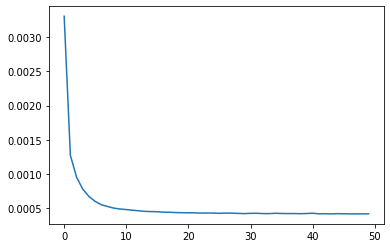

In [10]:
%matplotlib inline

plt.plot([i for i in range(len(full_loss))], full_loss)

In [15]:
def visualization(x):
    kx = get_minibatch(x,25,device)
    kx = add_noise(kx, std=1/3., device=device)
    gen = model.generate(kx).cpu().detach().numpy()
    kx = kx.cpu().detach().numpy()
    

    fig, ax = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax[i-1,j-1].axis("off")
            tmp = kx[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax[i - 1,j - 1].imshow(tmp,cmap="gray")
    
    
    
    
    fig2, ax2 = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax2[i-1,j-1].axis("off")
            tmp = gen[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax2[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig.show()
    fig2.show()

/tmp/ipykernel_107505/2716401791.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_107505/2716401791.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


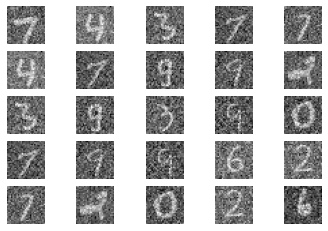

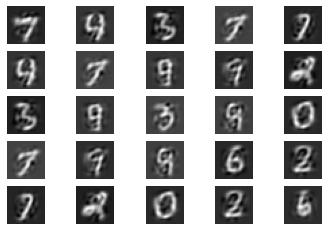

In [16]:
visualization(x)